In [2]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

np.random.seed(0)
plt.rcParams['figure.dpi']=300

/var/folders/13/r2qtp3l16ngdy08zglqkfxyc0000gn/T/ipykernel_5115/4246688029.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
mnist=fetch_openml("mnist_784", version=1)
X,Y=fetch_openml("mnist_784", version=1,return_X_y=True, as_frame= False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
print(X.shape) #le features sono i valori in scala di grigio dei pixels
#0 = nero , 255=bianco
X=X/255.0  #operazione di normalizzazione dei dati

(70000, 784)


In [5]:
#calcoliamouna permutazione di tutti i valori in maniera da mischiarli
shuffle=np.random.permutation(np.arange(X.shape[0]))
print(shuffle)
X, Y=X[shuffle], Y[shuffle] #scambiamo gli indici mantenendo la shape

[10840 56267 14849 ... 42613 43567 68268]


In [6]:
test_data, test_labels= X[60000:], Y[60000:]
train_data, train_labels=X[:60000], Y[:60000]

mini_train_data, mini_train_labels= X[:1000], Y[:1000]

<Axes: title={'center': 'Distribuzione delle label di uscita'}, xlabel='cifre', ylabel='frequenze per cifra'>

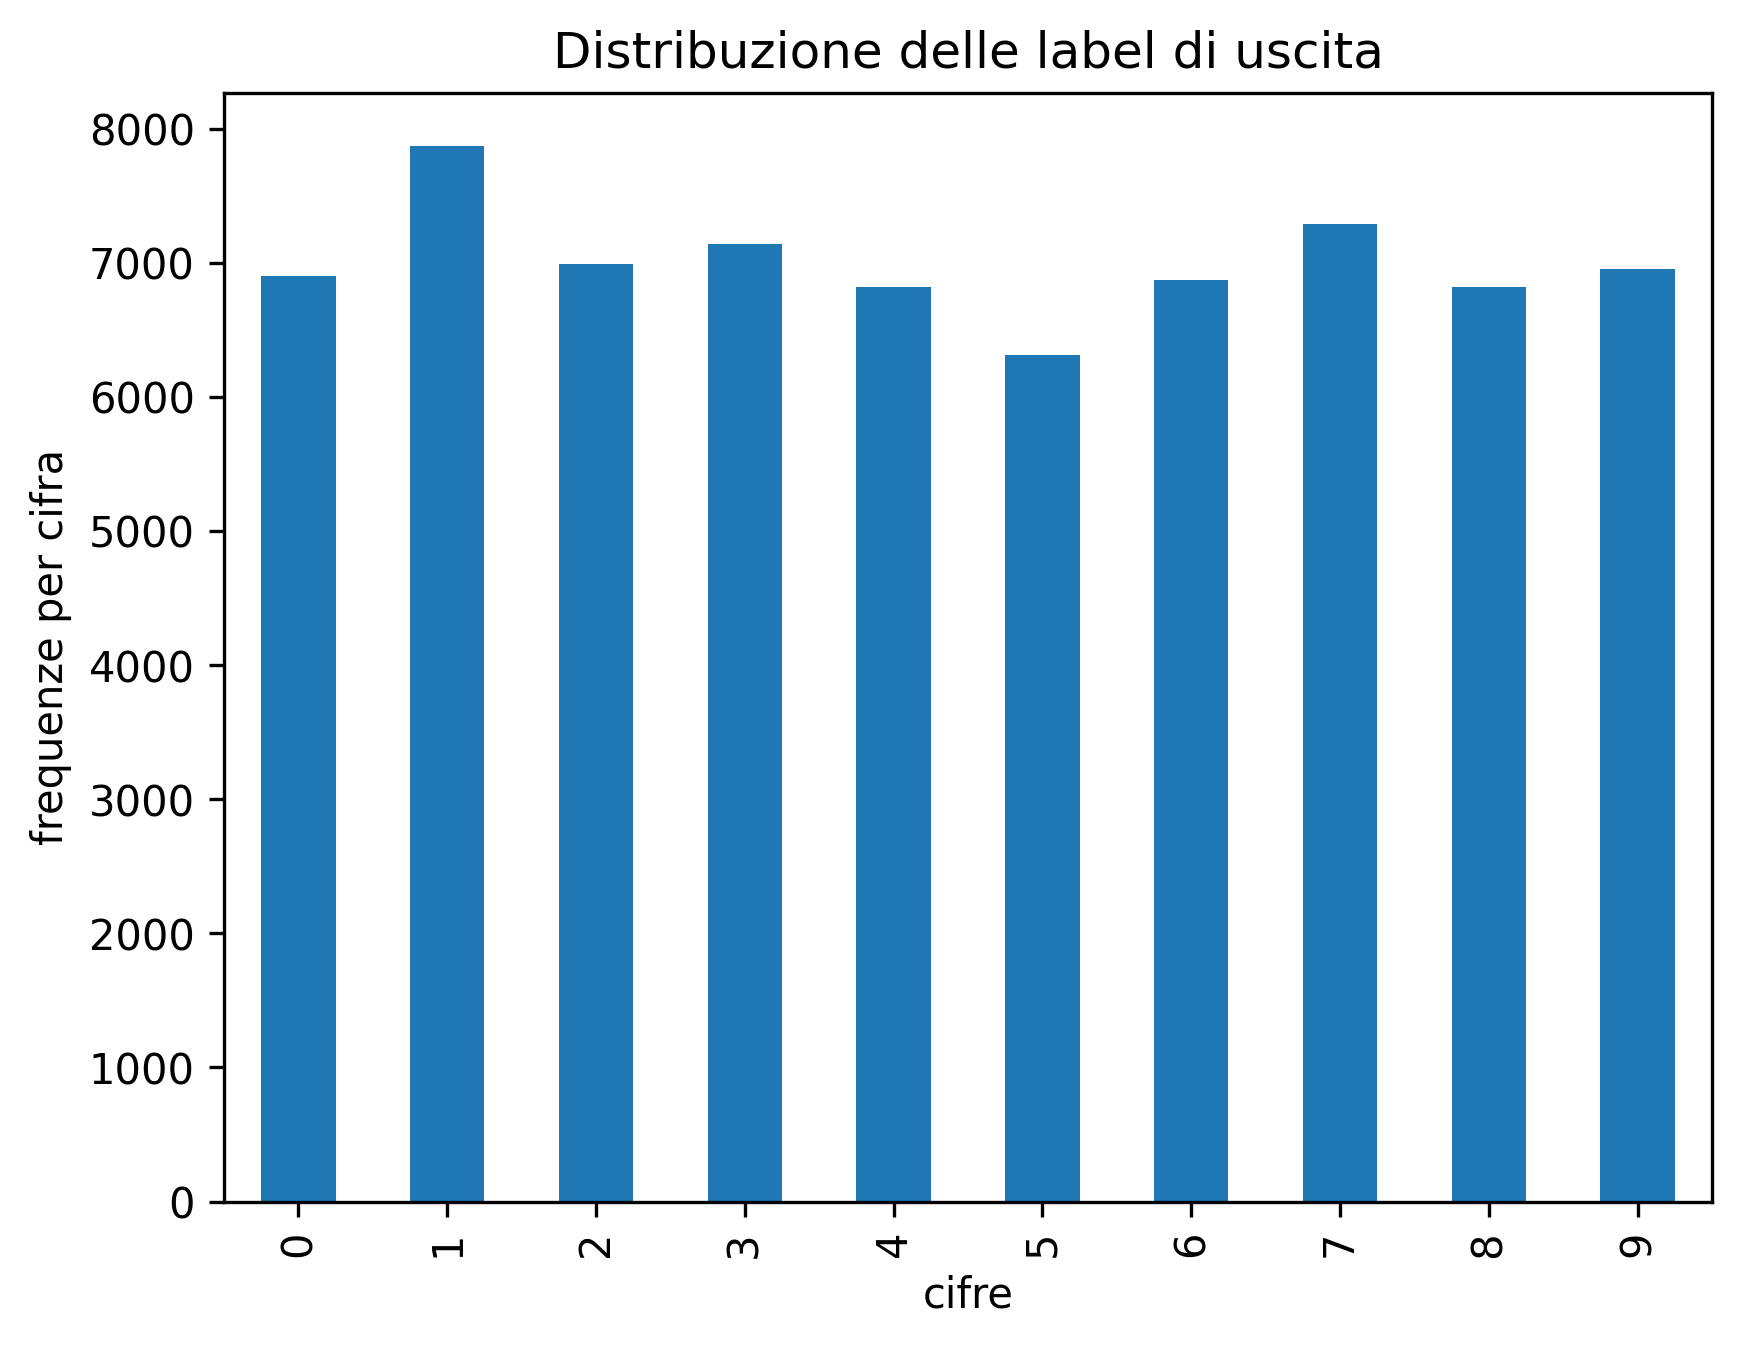

In [7]:
data= pd.DataFrame(Y)
data.pivot_table(index=0, aggfunc="size").plot(kind="bar", title="Distribuzione delle label di uscita", ylabel="frequenze per cifra", xlabel="cifre")

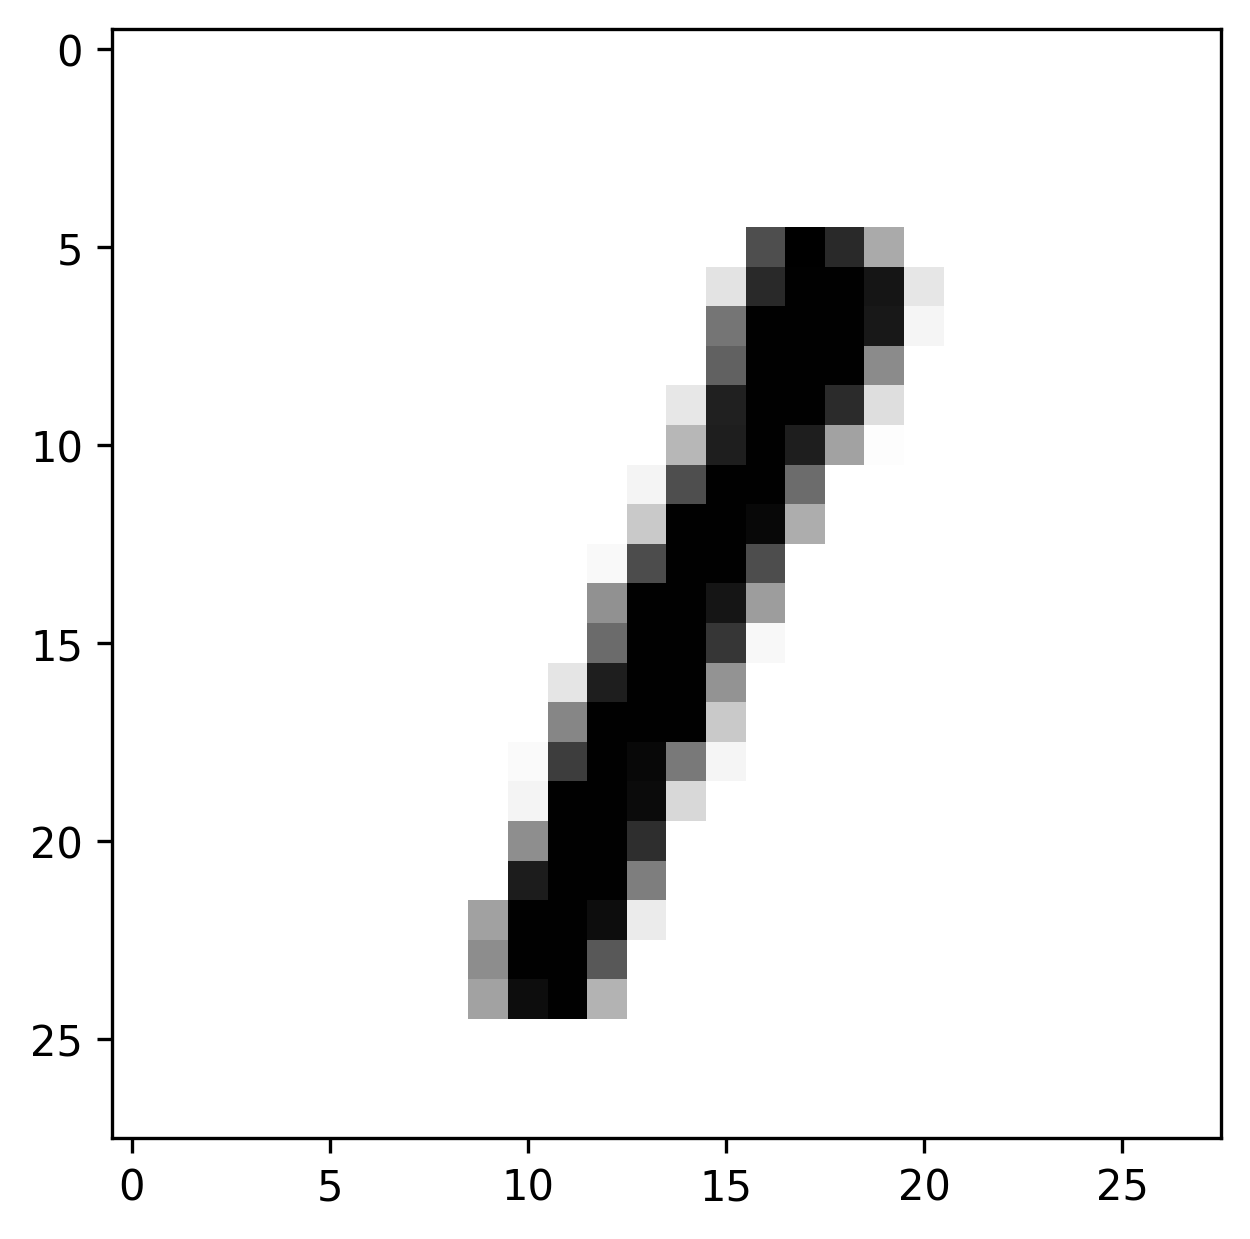

In [8]:
#creaimo una funzione che faccia il reshape di un dimensione
def reshape_number(row):
    return np.reshape(row,(28,28))

#reshaped=reshape_number(X[0])
#reshaped.shape

matrix=reshape_number(X[10])

plt.figure()
plt.imshow(matrix, cmap="binary")
plt.show()

In [9]:
def reshape_number(row):
    return np.reshape(row,(28,28))
#creiamo una immagine di 100 numeri che rappresnetano i primi 10 esempi presi dal dataset

print(mini_train_labels[:30])

'''
l=[
    [13,], #indici dei primi dieci zeri
    [...] #indici dei primi dieci 1
    ...
    [...] #indici dei primi dieci 9
]
'''

full_indices=[]
for digit in range(10):
    row=[]
    for i, label in enumerate(mini_train_labels):
        if int(label)==digit:
            row.append(i)
    full_indices.append(row)

print(full_indices[0])
print(full_indices[1])

limited_to_ten=[]
for full_row in full_indices:
    row=[]
    for i in full_row[:10]:
        row.append(i)
    limited_to_ten.append(row)

print(limited_to_ten[0]) #primi dueci indici della label 0
print(limited_to_ten[1])

['0' '4' '1' '2' '7' '9' '7' '1' '1' '7' '1' '3' '4' '2' '6' '4' '6' '7'
 '3' '3' '7' '0' '5' '7' '6' '5' '6' '4' '7' '4']
[0, 21, 32, 41, 44, 50, 55, 57, 58, 77, 80, 83, 91, 95, 104, 106, 121, 137, 144, 153, 155, 188, 207, 212, 220, 247, 249, 255, 274, 277, 290, 293, 296, 323, 360, 365, 367, 406, 418, 430, 438, 445, 454, 458, 482, 491, 492, 495, 496, 497, 520, 550, 574, 589, 593, 629, 633, 641, 658, 659, 660, 691, 712, 748, 761, 764, 771, 785, 806, 811, 828, 839, 842, 855, 865, 885, 899, 908, 915, 918, 948, 954, 958, 972, 973, 977, 978, 980, 996, 997, 999]
[2, 7, 8, 10, 33, 49, 51, 62, 88, 90, 101, 110, 119, 123, 124, 125, 140, 147, 157, 167, 170, 172, 183, 186, 198, 200, 202, 214, 221, 300, 302, 306, 341, 355, 389, 390, 395, 398, 399, 400, 434, 447, 456, 472, 473, 475, 500, 510, 513, 518, 526, 536, 556, 560, 561, 564, 569, 578, 580, 582, 585, 613, 614, 615, 630, 643, 651, 652, 666, 686, 694, 721, 739, 741, 751, 752, 753, 765, 784, 789, 792, 805, 808, 809, 817, 829, 869, 871, 876, 921

In [15]:
#modo alternativo
def draw_numbers_grid(n, labels=mini_train_labels, data=mini_train_data):
    full_indices=[]
    for digit in range(n):
        full_indices.append([i for i, label in enumerate(labels) if int(label)==digit])
#per ogni elemento nella lista vediamo se è uguale al digit del ciclo for trasformato in intero, se è vero prendiamo l'indice con quella label
    limited_indices=np.array([ [el for el in row[:n]] for row in full_indices])
    #per ciascune riga in full_indices aggiungi una nuova lista con i primi n elementi della riga
    print(limited_indices.shape)

    figure=plt.figure()
    fig, ax = plt.subplots(n,n, figsize=(12,12))

    for i, row in enumerate(limited_indices):
        for j, index in enumerate(row):
            example= data[index]
            matrix=reshape_number(example)
            ax[j,i].imshow(matrix)
            ax[j,i].set_xticks(np.array([]))
            ax[j,i].set_yticks(np.array([]))
    plt.show()

    return limited_indices

(10, 10)


<Figure size 1920x1440 with 0 Axes>

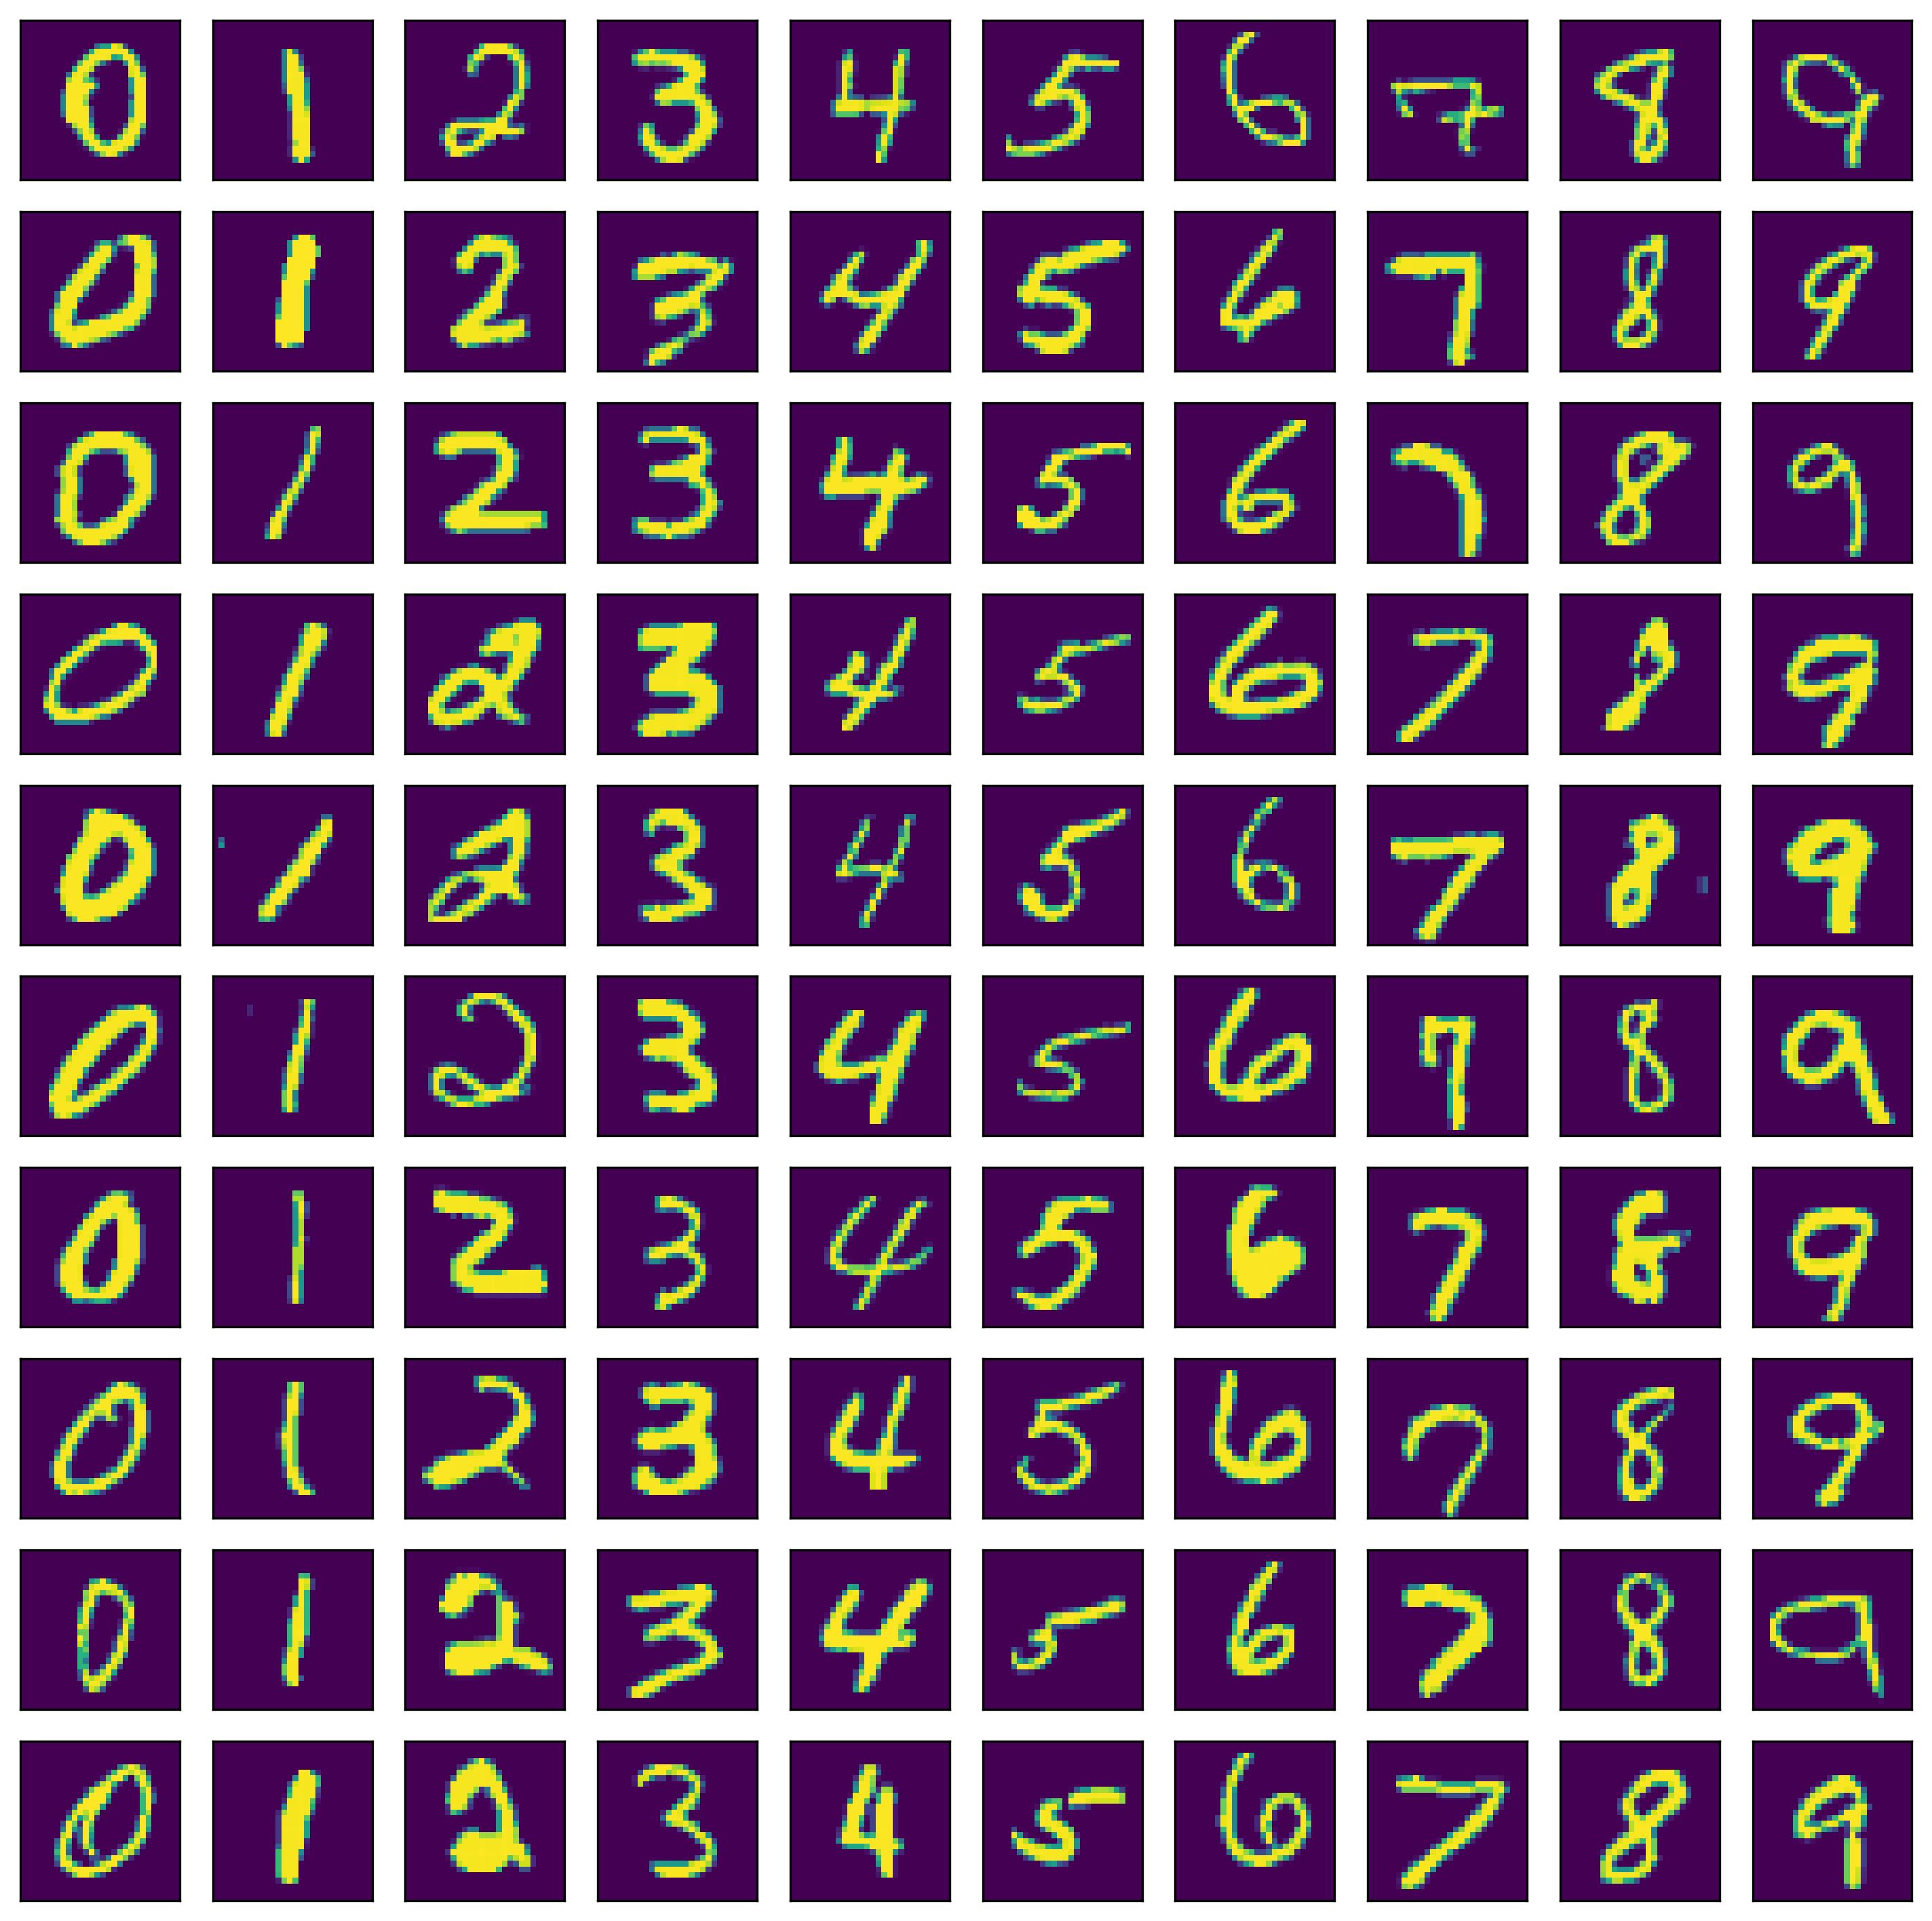

array([[  0,  21,  32,  41,  44,  50,  55,  57,  58,  77],
       [  2,   7,   8,  10,  33,  49,  51,  62,  88,  90],
       [  3,  13,  66,  68,  82,  87, 108, 117, 122, 131],
       [ 11,  18,  19,  30,  36,  52,  59,  72,  74, 102],
       [  1,  12,  15,  27,  29,  34,  38,  64,  69,  70],
       [ 22,  25,  31,  39,  47,  53,  54,  56,  61,  65],
       [ 14,  16,  24,  26,  35,  43, 113, 114, 115, 126],
       [  4,   6,   9,  17,  20,  23,  28,  46,  48,  60],
       [ 40,  63,  67,  78,  99, 105, 107, 120, 133, 138],
       [  5,  37,  42,  45,  85, 109, 111, 128, 134, 146]])

In [16]:
draw_numbers_grid(10)

In [17]:
print(mini_train_data[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [21]:
#binariziamo i dati
def binarize(data,threshold=0):
    d_copy=[[1 if value >= threshold else 0 for value in mnist_num] for mnist_num in data]
    return d_copy

#mini_train_binarized=binarize(mini_train_data[:1],0.5)
#print(mini_train_binarized)

def binarized_sklearn(data,threshold=0):
    from sklearn.preprocessing import Binarizer
    transformer= Binarizer(threshold=threshold).fit(data)
    d_copy=transformer.transform(data)

    return d_copy

mini_train_binarized_sklearn=binarized_sklearn(mini_train_data[:1],0.5)
print(mini_train_binarized_sklearn)

def ternarize(data,threshold_1=0.3333, threshold_2=0.6666):
    d_copy=[[1 if value>threshold_2 else 0.5 if value >threshold_1 else 0 for value in mnist_num] for mnist_num in data]
    return d_copy

ternarized= ternarize(mini_train_data[:1])
print(ternarized)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 

In [22]:
def print_classification_report(model, predictions, labels, names):
    print(f"classification report for {model}\n")
    print(classification_report(
        labels,
        predictions,
        target_names=names
    ))
    print(f"accuracy score:{accuracy_score(labels, predictions, normalize=True)}")


(10, 10)


<Figure size 1920x1440 with 0 Axes>

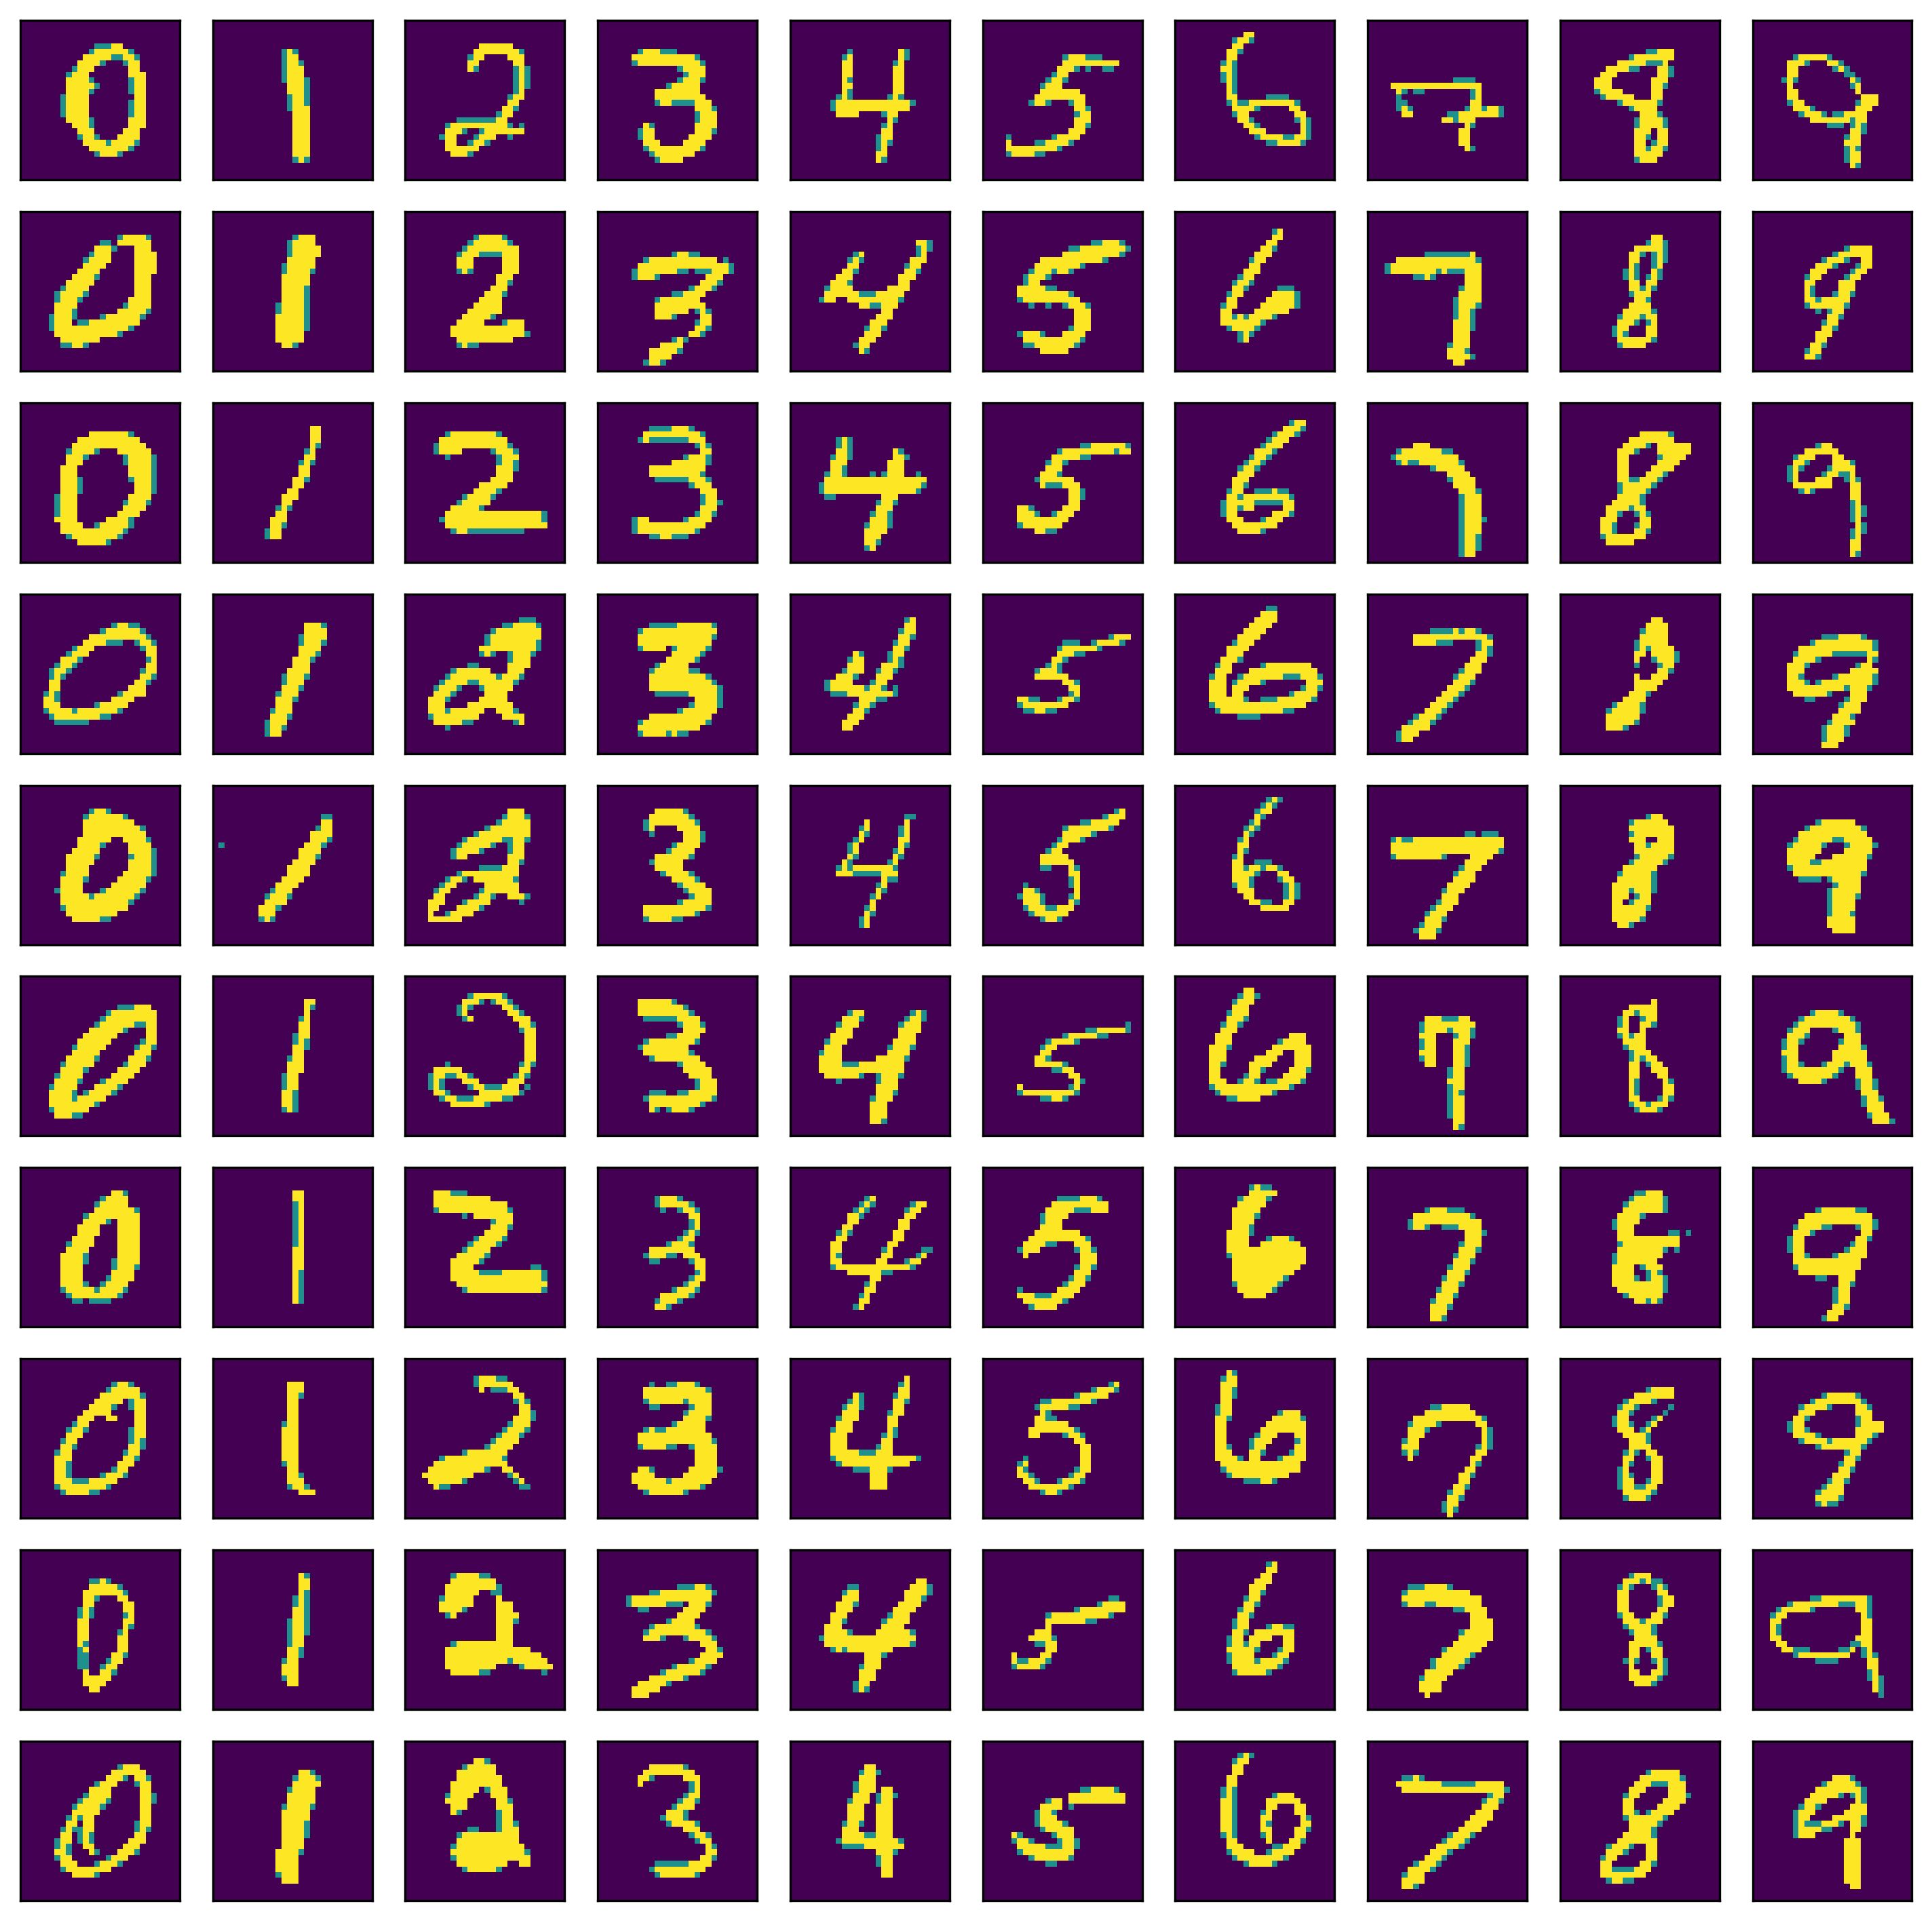

array([[  0,  21,  32,  41,  44,  50,  55,  57,  58,  77],
       [  2,   7,   8,  10,  33,  49,  51,  62,  88,  90],
       [  3,  13,  66,  68,  82,  87, 108, 117, 122, 131],
       [ 11,  18,  19,  30,  36,  52,  59,  72,  74, 102],
       [  1,  12,  15,  27,  29,  34,  38,  64,  69,  70],
       [ 22,  25,  31,  39,  47,  53,  54,  56,  61,  65],
       [ 14,  16,  24,  26,  35,  43, 113, 114, 115, 126],
       [  4,   6,   9,  17,  20,  23,  28,  46,  48,  60],
       [ 40,  63,  67,  78,  99, 105, 107, 120, 133, 138],
       [  5,  37,  42,  45,  85, 109, 111, 128, 134, 146]])

In [25]:
draw_numbers_grid(10, data=ternarize(mini_train_data[:200]))

In [26]:
target_name=[str(i) for i in range(10)]
bernoulli_nb=BernoulliNB()

binarize_train_data=binarize(train_data, 0.5)
binarize_test_data=binarize(test_data,0.5)

bernoulli_nb.fit(binarize_train_data, train_labels)
bernoulli_nb_predicted=bernoulli_nb.predict(binarize_test_data)

print_classification_report(bernoulli_nb, bernoulli_nb_predicted, test_labels, target_name)

classification report for BernoulliNB()

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       968
           1       0.87      0.94      0.91      1119
           2       0.88      0.82      0.84       991
           3       0.79      0.81      0.80      1046
           4       0.84      0.81      0.82       962
           5       0.81      0.74      0.77       873
           6       0.90      0.90      0.90      1008
           7       0.92      0.87      0.89      1041
           8       0.75      0.77      0.76      1002
           9       0.75      0.83      0.79       990

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

accuracy score:0.8413


In [27]:
ternarize_train_data=ternarize(train_data)
ternarize_test_data=ternarize(test_data)

multinomial_nb=MultinomialNB()

multinomial_nb.fit(ternarize_train_data,train_labels)
multinomial_nb_predicted=multinomial_nb.predict(ternarize_test_data)

print_classification_report(multinomial_nb,multinomial_nb_predicted,test_labels,target_name)

classification report for MultinomialNB()

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       968
           1       0.87      0.92      0.90      1119
           2       0.87      0.82      0.84       991
           3       0.80      0.82      0.81      1046
           4       0.84      0.75      0.79       962
           5       0.85      0.68      0.75       873
           6       0.89      0.91      0.90      1008
           7       0.94      0.84      0.89      1041
           8       0.66      0.77      0.71      1002
           9       0.71      0.84      0.77       990

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

accuracy score:0.8292


In [28]:
def smoothing_grid_search(model,alphas, data, labels):
    grid_search=GridSearchCV(
        model,
        alphas,
        verbose=3
    )

    grid_search.fit(data,labels)

    return grid_search

bernoulli_nb=BernoulliNB()
alphas={
    "alpha":[0.0001,0.001,0.01,0.1,1,10]
}

grid_search= smoothing_grid_search(
    bernoulli_nb,
    alphas,
    binarize_train_data,
    train_labels
)

print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......................alpha=0.0001;, score=0.831 total time=   2.7s
[CV 2/5] END ......................alpha=0.0001;, score=0.839 total time=   2.8s
[CV 3/5] END ......................alpha=0.0001;, score=0.837 total time=   2.8s
[CV 4/5] END ......................alpha=0.0001;, score=0.846 total time=   2.8s
[CV 5/5] END ......................alpha=0.0001;, score=0.836 total time=   2.8s
[CV 1/5] END .......................alpha=0.001;, score=0.831 total time=   2.8s
[CV 2/5] END .......................alpha=0.001;, score=0.840 total time=   2.8s
[CV 3/5] END .......................alpha=0.001;, score=0.837 total time=   2.8s
[CV 4/5] END .......................alpha=0.001;, score=0.846 total time=   2.9s
[CV 5/5] END .......................alpha=0.001;, score=0.836 total time=   2.9s
[CV 1/5] END ........................alpha=0.01;, score=0.831 total time=   2.9s
[CV 2/5] END ........................alpha=0.01;,

In [29]:
bernoulli_nb=BernoulliNB(**grid_search.best_params_)
#per ciascuna chiave in best_params uso quel valore
bernoulli_nb.fit(binarize_train_data, train_labels)
bernoulli_nb_predicted=bernoulli_nb.predict(binarize_test_data)

print_classification_report(bernoulli_nb, bernoulli_nb_predicted, test_labels, target_name)

classification report for BernoulliNB(alpha=0.0001)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       968
           1       0.87      0.94      0.91      1119
           2       0.87      0.82      0.85       991
           3       0.79      0.82      0.80      1046
           4       0.84      0.81      0.83       962
           5       0.80      0.74      0.77       873
           6       0.90      0.90      0.90      1008
           7       0.92      0.87      0.89      1041
           8       0.75      0.77      0.76      1002
           9       0.76      0.83      0.79       990

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

accuracy score:0.8428


l'accuracy migliora lievemente

In [30]:
gaussian_nb=GaussianNB().fit(train_data, train_labels)

gaussian_nb_predicted=gaussian_nb.predict(test_data)
print_classification_report(gaussian_nb,gaussian_nb_predicted,test_labels,target_name)

classification report for GaussianNB()

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       968
           1       0.80      0.94      0.86      1119
           2       0.86      0.30      0.44       991
           3       0.76      0.40      0.52      1046
           4       0.87      0.17      0.28       962
           5       0.57      0.07      0.13       873
           6       0.64      0.94      0.76      1008
           7       0.88      0.32      0.47      1041
           8       0.30      0.66      0.42      1002
           9       0.40      0.95      0.57       990

    accuracy                           0.57     10000
   macro avg       0.69      0.57      0.53     10000
weighted avg       0.69      0.57      0.54     10000

accuracy score:0.5747


l'accuracy peggiora di molto

In [35]:
theta=gaussian_nb.theta_ #medie di ogni features per ogni classe
var=gaussian_nb.var_
print(theta.shape)
print(theta[1][0]) #media di tutte le osservazioni con label di uscita pari a 1

print(var.shape)

(10, 784)
0.0
(10, 784)


<Figure size 1920x1440 with 0 Axes>

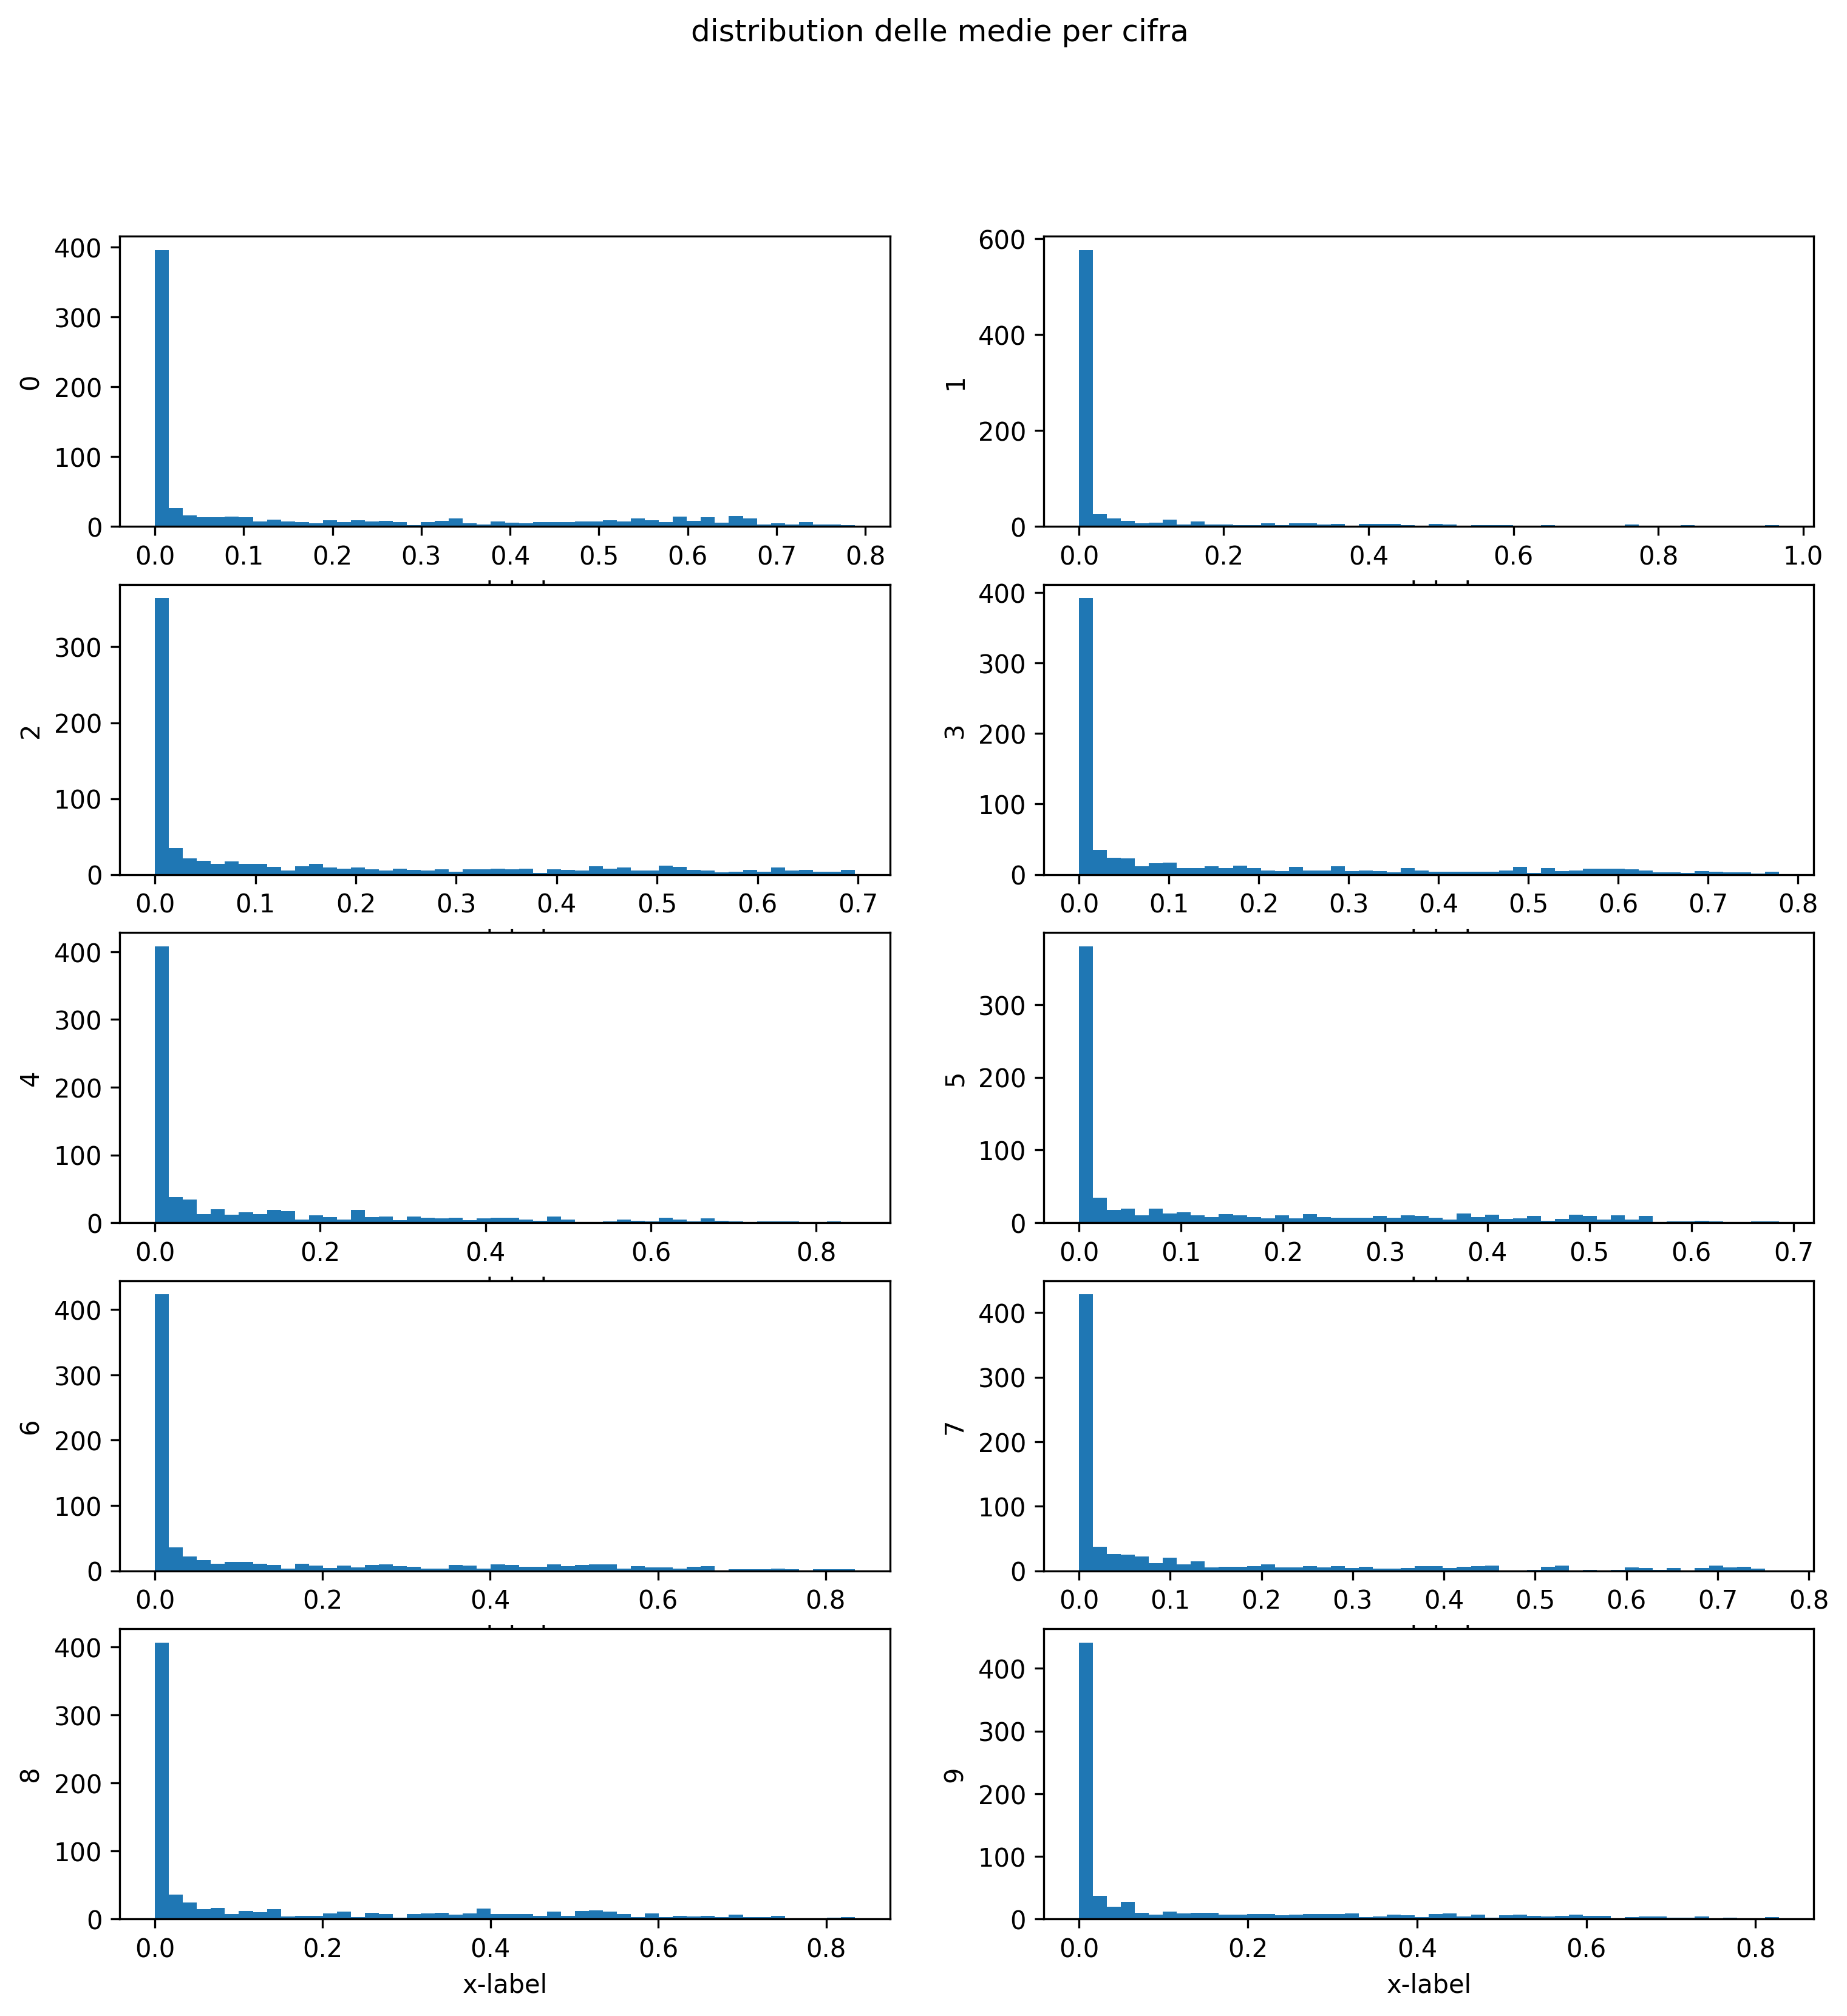

In [33]:
def draw_histograms(elems, title, bins=50):
    figure=plt.figure()
    fig, axs=plt.subplots(5,2,figsize=(12,12))
    fig.suptitle(title)
    for i, ax in enumerate(axs.flat):
        ax.hist(elems[i], bins=bins)
        ax.set(xlabel="x-label", ylabel=f"{i}")

draw_histograms(theta, "distribution delle medie per cifra")

<Figure size 1920x1440 with 0 Axes>

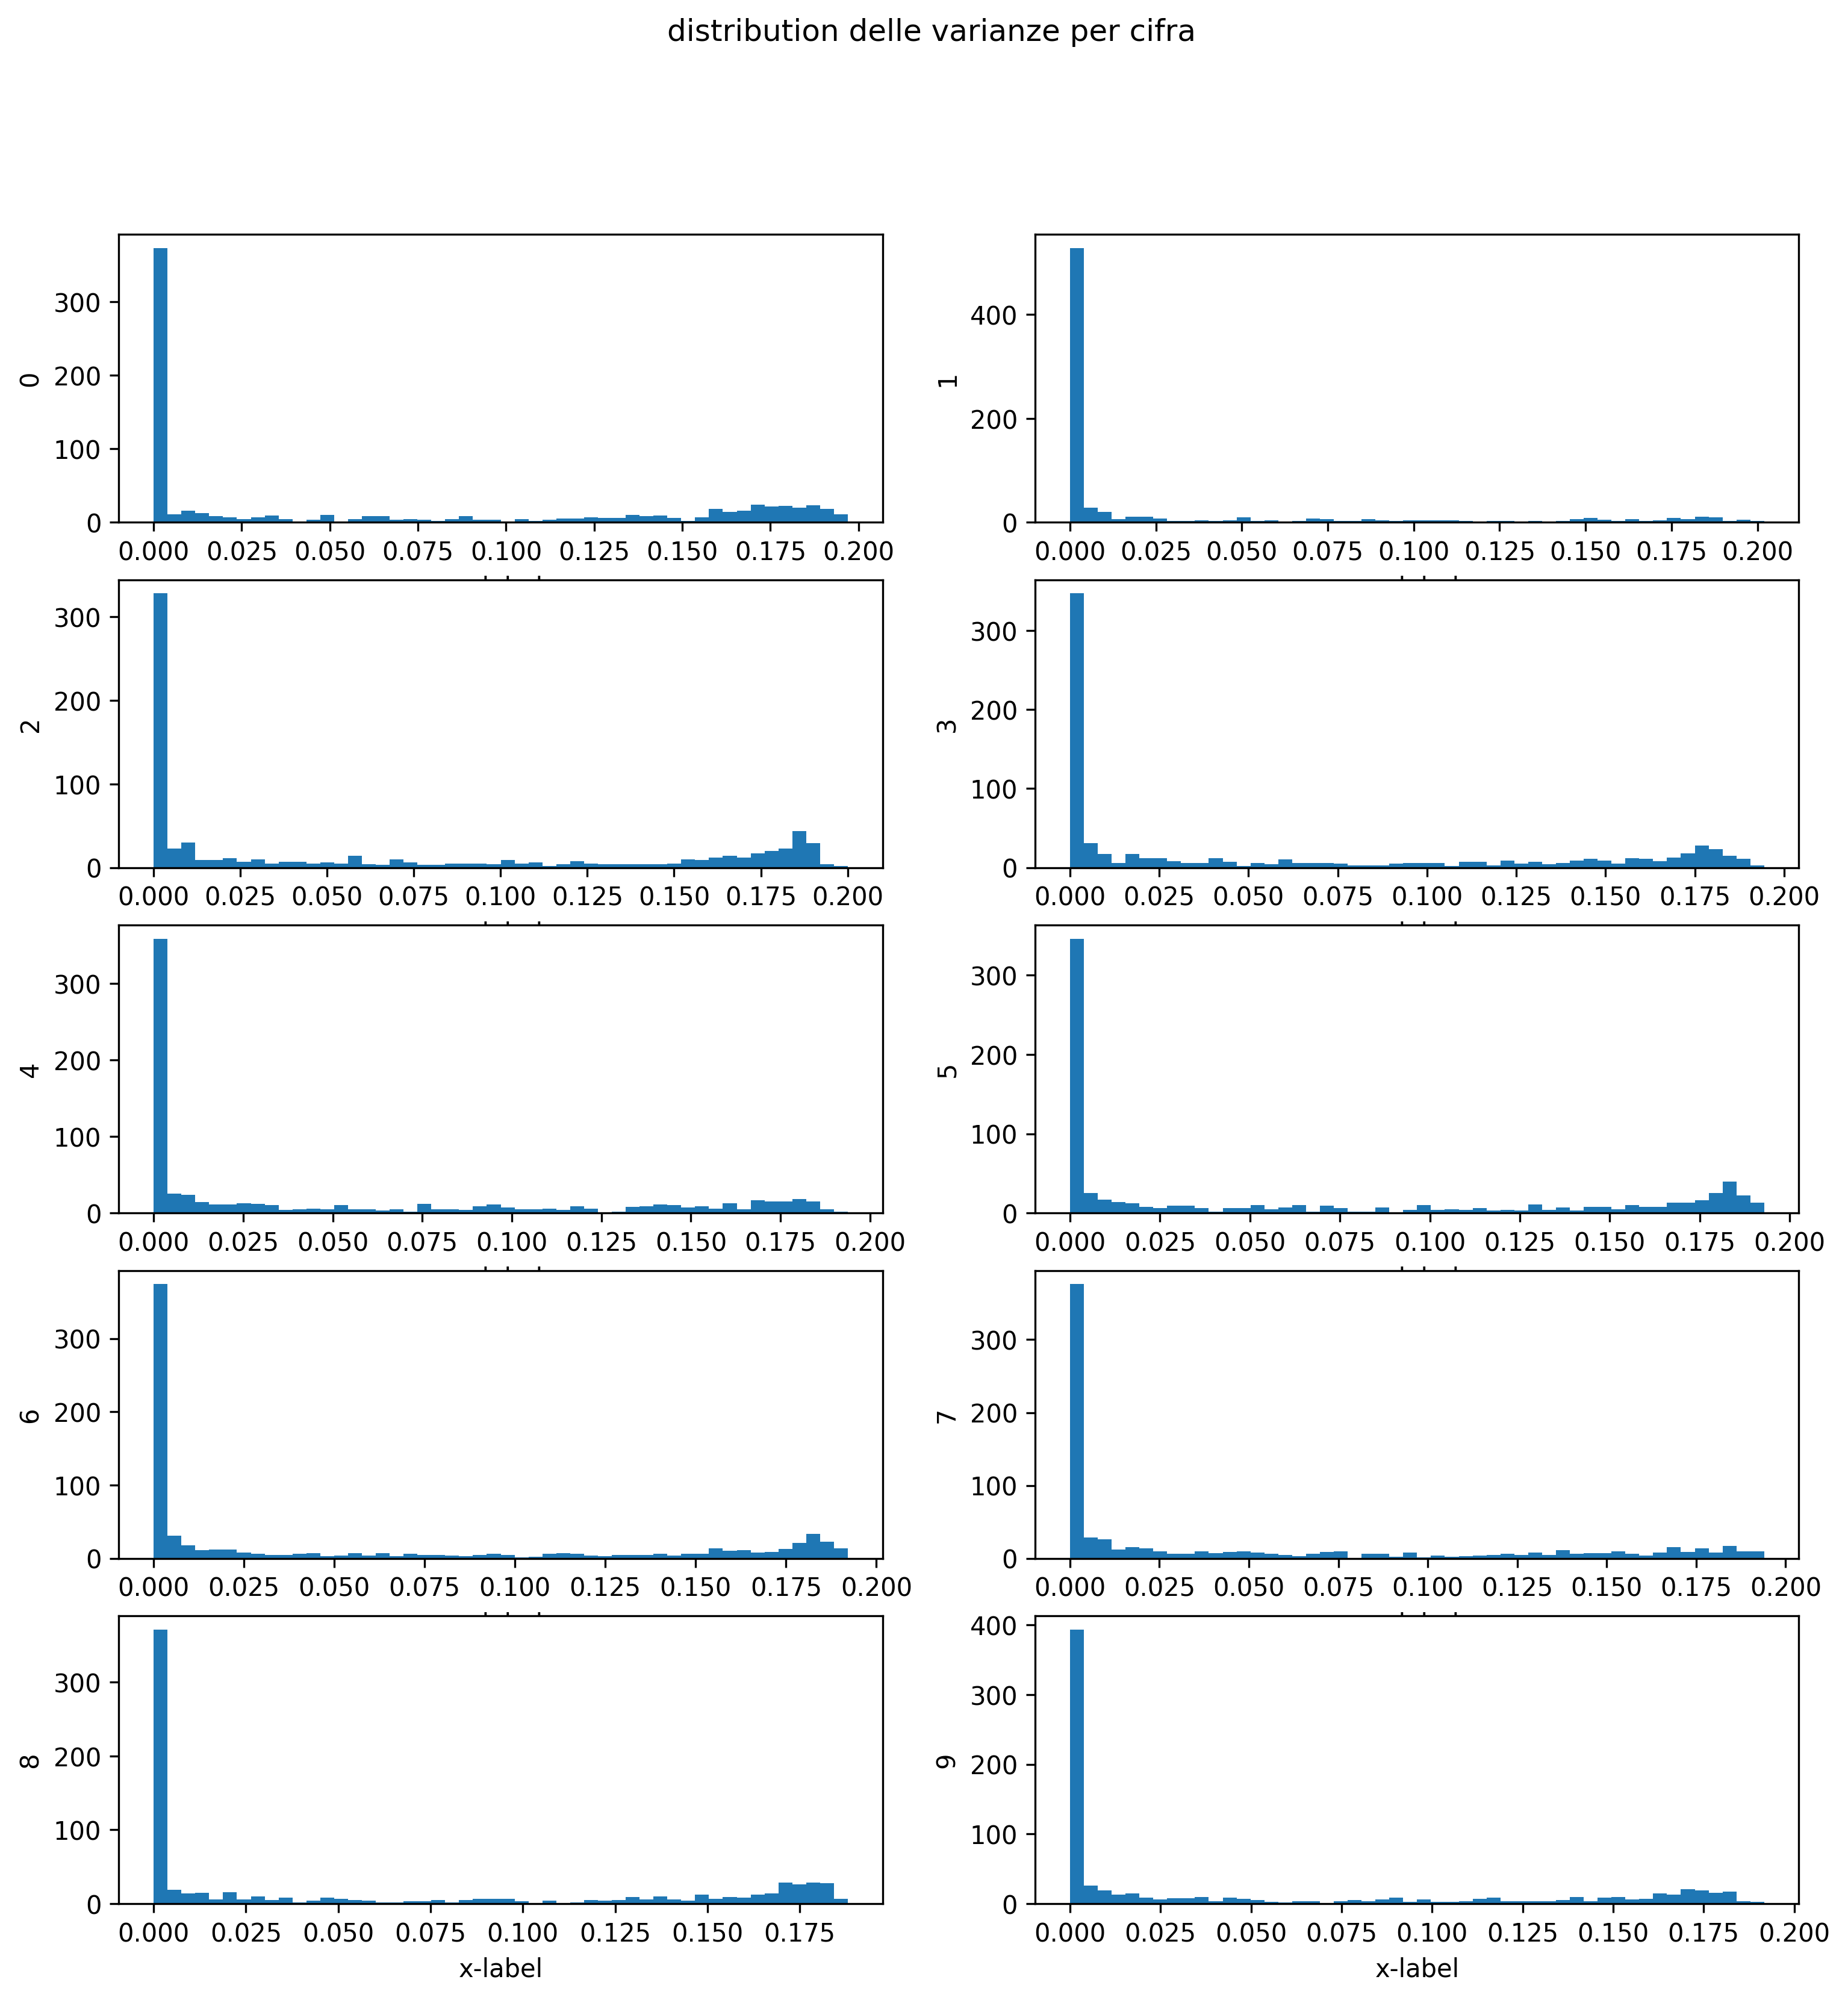

In [36]:
draw_histograms(var, "distribution delle varianze per cifra")

la maggioranza dei pixels delle nostre immagini ha valore zero, quindi sbilancia le osservazioni, le gaussiane sono tutte one-tail

In [37]:
nb=GaussianNB()
params={"var_smoothing":[i for i in np.arange(0.1,1.1,0.1)]}
gaussian_grid_search=smoothing_grid_search(nb,params, train_data,train_labels)

print(gaussian_grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .................var_smoothing=0.1;, score=0.798 total time=   0.6s
[CV 2/5] END .................var_smoothing=0.1;, score=0.800 total time=   0.5s
[CV 3/5] END .................var_smoothing=0.1;, score=0.805 total time=   0.5s
[CV 4/5] END .................var_smoothing=0.1;, score=0.813 total time=   0.5s
[CV 5/5] END .................var_smoothing=0.1;, score=0.803 total time=   0.5s
[CV 1/5] END .................var_smoothing=0.2;, score=0.790 total time=   0.5s
[CV 2/5] END .................var_smoothing=0.2;, score=0.792 total time=   0.5s
[CV 3/5] END .................var_smoothing=0.2;, score=0.799 total time=   0.5s
[CV 4/5] END .................var_smoothing=0.2;, score=0.806 total time=   0.5s
[CV 5/5] END .................var_smoothing=0.2;, score=0.797 total time=   0.5s
[CV 1/5] END .var_smoothing=0.30000000000000004;, score=0.781 total time=   0.5s
[CV 2/5] END .var_smoothing=0.30000000000000004;

In [38]:
nb=GaussianNB(**gaussian_grid_search.best_params_)
nb.fit(train_data, train_labels)

nb_predicted=nb.predict(test_data)

print_classification_report(nb,nb_predicted,test_labels,target_name)

classification report for GaussianNB(var_smoothing=0.1)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       968
           1       0.76      0.96      0.85      1119
           2       0.91      0.74      0.81       991
           3       0.81      0.79      0.80      1046
           4       0.84      0.66      0.74       962
           5       0.89      0.64      0.74       873
           6       0.86      0.92      0.89      1008
           7       0.94      0.83      0.88      1041
           8       0.70      0.74      0.72      1002
           9       0.64      0.87      0.74       990

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

accuracy score:0.8104


BernoulliNB(alpha=0.0001)
(10, 784)
(10, 10, 784)


<Figure size 1920x1440 with 0 Axes>

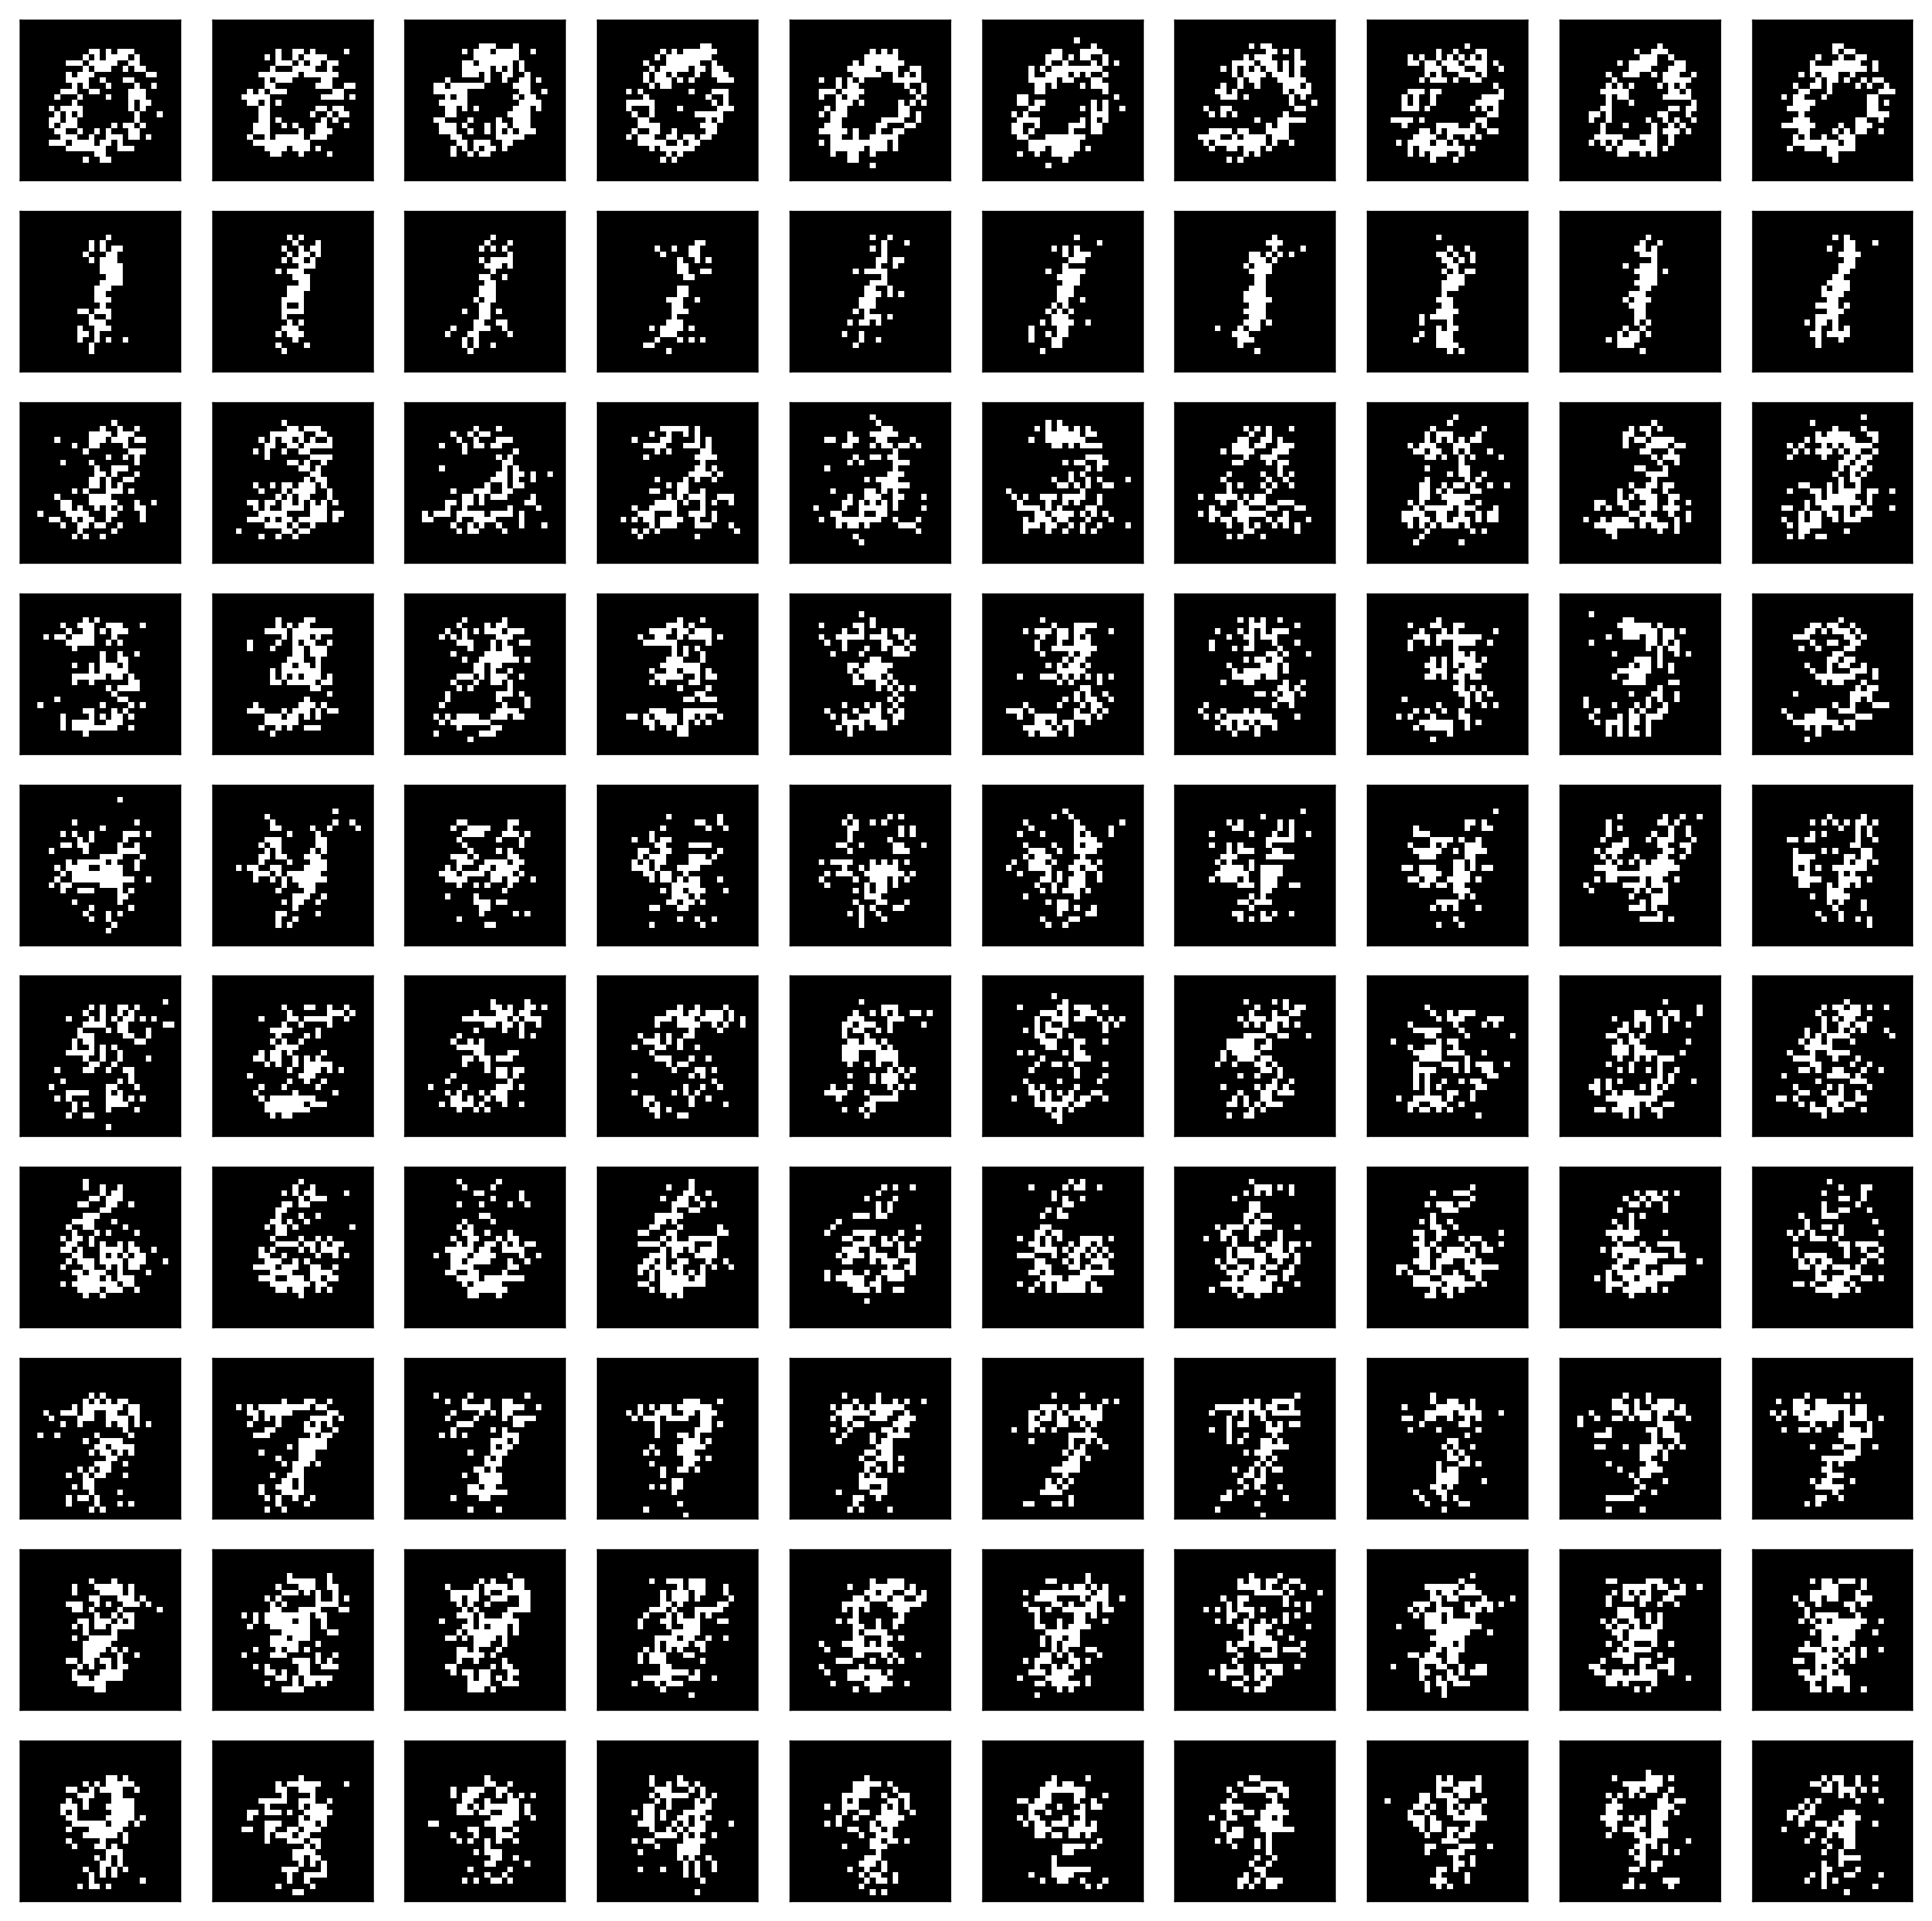

In [42]:
print(bernoulli_nb)

feature_prob=np.exp(bernoulli_nb.feature_log_prob_)
print(feature_prob.shape)

generated=[]
#se il numero generato per ciascuna feature è minore della probabilità per quella feature 
#disegnamo uno zero, else 1
for i in range(10):
    row=[]
    for digit in range(10):
        probs=feature_prob[digit]
        image=[1.0 if np.random.uniform() >= p else 0 for p in probs]
        row.append(image)
    generated.append(row)

print(np.array(generated).shape)

figure=plt.figure()
d=10
fig, axs=plt.subplots(d,d,figsize=(12,12))
for i in range(d):
    for j, row in enumerate(generated):
        axs[i,j].imshow(reshape_number(row[i]), cmap="binary")
        axs[i,j].set_xticks(np.array([]))
        axs[i,j].set_yticks(np.array([]))
plt.show()

i numeri sono riconoscibili perche naive bayes è un algoritmro generativo, a prescindere dalla distribuzione dei dati è in grado di generare delle osservazioni sintetiche oltre che fare previsioni sulle osservazioni gia esistenti.